# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb

from collections import defaultdict

In [2]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q26_2** Did you and [Partner name] attend the same college or university?
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [3]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [4]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes

In [5]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


## Zmiana w średniej odpowiedzi modelu

Wylosujemy jakąś osobę z populacji i dla niej zbadamy jak jej kolejne cechy wpływały na odpowiedź modelu. Warto najpierw zauważyć, że osoba ta ma 97% szans według modelu na bycie w związku małżeńskim.

In [113]:
colnames = X_train.columns
names_explained_list = ["same_sex", "high_school", "university", "met_online", "partner_age", "w6_q24_length"]
names_explained = {colname: colname_explained for colname, colname_explained in zip(colnames, names_explained_list)}

In [89]:
column_order = ["Q5", "Q25_2", "Q26_2", "hcm2017q24_met_online", "w6_q9", "w6_q24_length"]

In [96]:
class AttributionPlotter:
    def __init__(self, model, data, verbose=False):
        self.model = model
        self.data = data
        self.verbose = verbose

    def get_mean_proba(self, data_subset):
        predictions = self.model.predict_proba(data_subset.loc[:, self.data.columns])
        return np.mean(predictions[:, 0])
    
    def _get_data_subset(self, person, i):
       #"""Returns subset of X for which first i column of X are the same as first i columns of person"""
        match = self._X.iloc[:, 0:(i+1)].values == person.iloc[:, 0:(i+1)].values
        indexes = np.apply_along_axis(all, 1, match)
        if self.verbose:
            print(f"For first {i+1} columns got {np.sum(indexes)} observations")
        return self._X[indexes]

    def _get_attribution_probas(self, column_order):
        
        predicted_probas = [self.get_mean_proba(self._X)]
        for i in range(len(column_order), ):
            proba = self.get_mean_proba(self._get_data_subset(self._person, i))
            predicted_probas.append(proba)
        return predicted_probas

    def plot_attributions(self, person, column_order):
        import waterfall_chart
        self._X = self.data.copy()[column_order]
        self._person = person.copy()[column_order]
        probas = self._get_attribution_probas(column_order)
        if(self.verbose):
            print(probas)
        waterfall_chart.plot(["Intercept"] + [names_explained[col] for col in column_order], np.concatenate([[probas[0]], np.ediff1d(probas)]),
                            rotation_value=50,
                            formatting='{:,.2f}')

In [100]:
attributionPlotter = AttributionPlotter(xgb_model, pd.concat([X_train, X_test]), verbose=True)

#### Osoba 1 

In [114]:
random.seed(1234)
random_person = X_test.iloc[random.choice(range(0, len(X_test)))]
random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
print(random_person)
print("Predicted probabilities:", xgb_model.predict_proba(random_person))
for colname, code in zip(random_person.columns, random_person.iloc[0]):
    print(colname, name_from_code[colname](code))
married = xgb_model.predict(random_person)
print("S1 - prediction", name_from_code["S1"](married))

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0   -1.0   -1.0                    0.0   70.0          158.0
Predicted probabilities: [[0.97045314 0.02954684]]
Q5 nan
Q25_2 nan
Q26_2 nan
hcm2017q24_met_online no
w6_q9 70.0
w6_q24_length 158.0
S1 - prediction Index(['Yes, I am Married'], dtype='object')


For first 1 columns got 3042 observations
For first 2 columns got 2504 observations
For first 3 columns got 2504 observations
For first 4 columns got 2174 observations
For first 5 columns got 42 observations
For first 6 columns got 1 observations
[0.59809494, 0.61380106, 0.74502605, 0.74502605, 0.80424875, 0.9638988, 0.97045314]


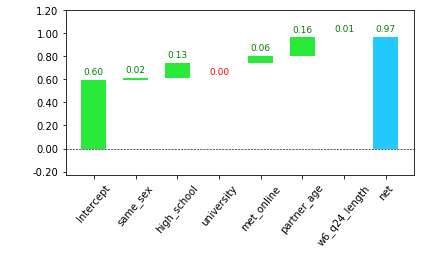

In [101]:
attributionPlotter.plot_attributions(random_person, column_order)

In [102]:
random_column_order = random.sample(column_order, len(column_order))

W poniższym wykresie uwidacznia się problem dla zmiennych ciągłych: może nie być wcale obserwacji o dokładnie takich samych wartościach zmiennej ciagłej, albo może ich byc bardzo mało. Żeby otrzymać bardziej interesujące wyniki warto umieszczać zmienne kategoryczne na początku, albo dopuszczać wartości z pewnych przedziałów dla zmiennych ciągłych.

Na poniższym rysunku możemy być zadowoleni z faktu, że wiek parnera okazał się istotnym czynnikiem - jeżeli w wieku 70 lat ma się partnera, to raczej jest to małżonek.

For first 1 columns got 3042 observations
For first 2 columns got 10 observations
For first 3 columns got 1 observations
For first 4 columns got 1 observations
For first 5 columns got 1 observations
For first 6 columns got 1 observations
[0.59809494, 0.61380106, 0.6552078, 0.97045314, 0.97045314, 0.97045314, 0.97045314]


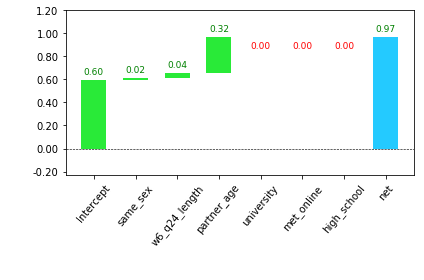

In [104]:
attributionPlotter.plot_attributions(random_person, random_column_order)

#### Osoba 2
Zobaczmy jeszcze wyniki dla innej losowej osoby.

In [109]:
random.seed(99)
random_person = X_test.iloc[random.choice(range(0, len(X_test)))]
random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
print(random_person)
print("Predicted probabilities:", xgb_model.predict_proba(random_person))
for colname, code in zip(random_person.columns, random_person.iloc[0]):
    print(names_explained[colname], name_from_code[colname](code))
married = xgb_model.predict(random_person)
print("S1 - prediction", name_from_code["S1"](married))

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0   -1.0   -1.0                    0.0   29.0          268.0
Predicted probabilities: [[0.73785603 0.26214394]]
same_sex nan
high_school nan
university nan
met_online no
partner_age 29.0
w6_q24_length 268.0
S1 - prediction Index(['Yes, I am Married'], dtype='object')


For first 1 columns got 3042 observations
For first 2 columns got 2504 observations
For first 3 columns got 2504 observations
For first 4 columns got 2174 observations
For first 5 columns got 42 observations
For first 6 columns got 1 observations
[0.59809494, 0.61380106, 0.74502605, 0.74502605, 0.80424875, 0.6401839, 0.73785603]


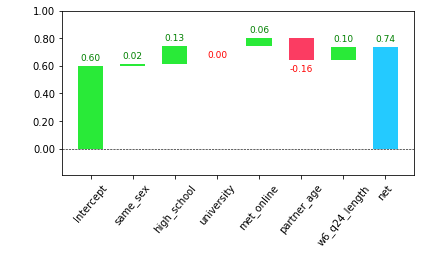

In [110]:
attributionPlotter.plot_attributions(random_person, column_order)

In [111]:
random_column_order = random.sample(column_order, len(column_order))
random_column_order

['hcm2017q24_met_online', 'Q25_2', 'w6_q9', 'Q5', 'Q26_2', 'w6_q24_length']

Wyniki dla innej permutacji kolum sa podobne, nie widzimy ciekawych zależności między zmiennymi. Dobrze, że wiek partnera (29) miał negatywny wpływ na prawodpodobieństwo, ale nie wiem czy to dobrze, że zmienne które były NaNami podnosza czasem prawdopodobieństwo bycia w związku małżeńskim.

For first 1 columns got 2992 observations
For first 2 columns got 2527 observations
For first 3 columns got 53 observations
For first 4 columns got 42 observations
For first 5 columns got 42 observations
For first 6 columns got 1 observations
[0.59809494, 0.6532294, 0.7727943, 0.5981224, 0.6401839, 0.6401839, 0.73785603]


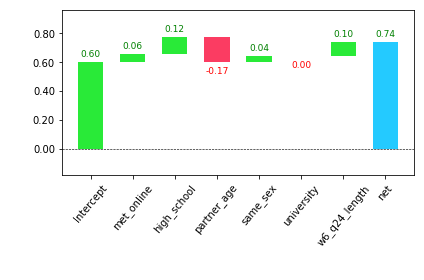

In [112]:
attributionPlotter.plot_attributions(random_person, random_column_order)

#### Osoba 3
Na poniższym wykresie możemy zauważyć jak fakt poznania się online oraz bycie w związku z osoba tej samej płci zmniejsza szanse na bycie małżeństwem.

In [122]:
X_gay = X_test.loc[X_test["Q5"] == 0]
random_person = X_gay.iloc[random.choice(range(0, len(X_gay)))]
random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
print(random_person)
print("Predicted probabilities:", xgb_model.predict_proba(random_person))
for colname, code in zip(random_person.columns, random_person.iloc[0]):
    print(names_explained[colname], name_from_code[colname](code))
married = xgb_model.predict(random_person)
print("S1 - prediction", name_from_code["S1"](married))

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0  0.0   -1.0   -1.0                    1.0   41.0          124.0
Predicted probabilities: [[0.36568218 0.6343178 ]]
same_sex Yes, we are a same-sex couple
high_school nan
university nan
met_online yes
partner_age 41.0
w6_q24_length 124.0
S1 - prediction Index(['No, I am not Married'], dtype='object')


For first 1 columns got 402 observations
For first 2 columns got 329 observations
For first 3 columns got 5 observations
For first 4 columns got 1 observations
For first 5 columns got 1 observations
For first 6 columns got 1 observations
[0.59809494, 0.34840402, 0.42562893, 0.7308466, 0.36568218, 0.36568218, 0.36568218]


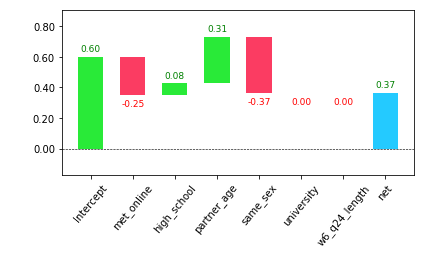

In [123]:
attributionPlotter.plot_attributions(random_person, random_column_order)